In [6]:
# Cell 1: Install Dependencies
# Run this cell once
!pip install  hdbscan 
!pip install jupyter ipykernel pymupdf sentence-transformers scikit-learn umap-learn matplotlib pytesseract

In [7]:
# Cell 2: Import Libraries
%pip install hdbscan

import fitz  # PyMuPDF
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import hdbscan
import umap
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image


Note: you may need to restart the kernel to use updated packages.


In [8]:
# Cell 3: Extract Pages from PDF (Enhanced OCR Preprocessing)
from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import pytesseract
import fitz  # PyMuPDF

def preprocess_image_for_ocr(img):
    # Convert to grayscale
    img = img.convert('L')
    # Increase contrast
    enhancer = ImageEnhance.Contrast(img)
    img = enhancer.enhance(2.0)
    # Binarize (threshold)
    img = img.point(lambda x: 0 if x < 160 else 255, '1')
    # Resize to improve OCR (increase DPI)
    base_width = 1800
    wpercent = (base_width / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((base_width, hsize), Image.LANCZOS)
    return img

def extract_pages(pdf_path):
    doc = fitz.open(pdf_path)
    pages = []
    for i, page in enumerate(doc):
        text = page.get_text("text").strip()
        if text:
            pages.append({"page": i, "text": text})
        else:
            # Enhanced OCR fallback
            pix = page.get_pixmap(dpi=300)
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            img = preprocess_image_for_ocr(img)
            text = pytesseract.image_to_string(img, config='--psm 6')
            pages.append({"page": i, "text": text if text.strip() else "[EMPTY]"})
    return pages

# Example usage
pdf_path = r"C:\Users\PawanMagapalli\Downloads\ilovepdf_merged.pdf"
pages = extract_pages(pdf_path)
print(f"Total pages extracted: {len(pages)}")
print(pages[0])

Total pages extracted: 29
{'page': 0, 'text': 'dotloop signature verification: dtlp.usliVMM PGJU T5h6 \nFHA/VA Addendum for Real Estate Certification \nBuyer(s) JOHN HOMEOWNER \nSeller(s) SALLY SELLER LLC \nProperty Address 123 TEST DRIVE Bessemer. AL \n35023 \nFHA/VA Amendatory Clause \nAgreement Date 07/24/2024 \nFile Number --------\nIt is expressly agreed that notwithstanding any other provisions of this contract, the purchaser shall not be obligated to \ncomplete the purchase of the property described herein or to incur any penalty by forfeiture of earnest money deposits or \notherwise unless the purchaser has been given in accordance with HUD/FHA or VA requirements a written statement by \nthe Federal Housing Commissioner, Department of Veterans Affairs, or a Direct Endorsement lender setting forth the \nappraised value of the property of not less than $_128,000 \n(sales price in Purchase Agreement). The \npurchaser shall have the privilege and option of proceeding with consummat

In [9]:
# Cell: EasyOCR Fallback for Image-based Pages
# Install EasyOCR if not already installed
!pip install easyocr
import easyocr
reader = easyocr.Reader(['en'])

def extract_text_with_easyocr(img):
    # img: PIL Image
    img_np = np.array(img)
    result = reader.readtext(img_np, detail=0)
    return '\n'.join(result)

# Enhanced extract_pages with EasyOCR fallback

def extract_pages_with_easyocr(pdf_path):
    doc = fitz.open(pdf_path)
    pages = []
    for i, page in enumerate(doc):
        text = page.get_text("text").strip()
        if text:
            pages.append({"page": i, "text": text})
        else:
            pix = page.get_pixmap(dpi=300)
            img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
            img = preprocess_image_for_ocr(img)
            # Try pytesseract first
            text = pytesseract.image_to_string(img, config='--psm 6')
            if not text.strip() or text.strip() == "[EMPTY]":
                # Fallback to EasyOCR
                text = extract_text_with_easyocr(img)
            pages.append({"page": i, "text": text if text.strip() else "[EMPTY]"})
    return pages

# Example usage
pdf_path = "ilovepdf_merged.pdf"
pages = extract_pages_with_easyocr(pdf_path)
print(f"Total pages extracted: {len(pages)}")
print(pages[0])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Total pages extracted: 4
{'page': 0, 'text': "‘OMB No, 1585-0008 FMB No. 1548-0008\n@ Control Number 7 Wages, bps, other compensation 2 Federal income tax withheld i @ Control Number T Wages, ips, other compensation rederal eame tax withheld\n225464.74 31269.71 : 225454.74 312€9.71\nib Employer identification number (EIN) [3 Social security wages “4 Social security tax withheld } Employer identifcation number (EIN) | 9 Social secunly wages 4 Social security tax withheld\n943-88-7798 160200.00 9932.40 i 943-88-7798 160200.00 9932.40\na Employee's sacial security number [5 Macicare wages and tos, 6 Medicare tax withheld 2 3 Employee's social seourity number | § Medicare wages and tips @ Medicare tax withheld\n341-81-009 251207.44 4103.38 i 341-81-009 P5I207.44 4103.38\n© Employer's name, address and ZIP code  @ Employers name, address and ZIP code\nPVI INDUSTRIA WASHING, INC, : PVI INDUSTRIA WASHING, INC.\n288 CLYDON AVE.SW WYOMING, MT i 288 CLYDON AVE.SW WYOMING, MT\n49519 i 49519\n10 D

In [10]:
# Cell: Save Preprocessed Images and Extracted Text for Debugging
import os
img_debug_dir = "output_preprocessed_images"
os.makedirs(img_debug_dir, exist_ok=True)
text_debug_dir = "output_extracted_text_easyocr"
os.makedirs(text_debug_dir, exist_ok=True)

pdf_path = r"C:\Users\PawanMagapalli\Downloads\ilovepdf_merged.pdf"
doc = fitz.open(pdf_path)
for i, page in enumerate(doc):
    pix = page.get_pixmap(dpi=300)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    img_proc = preprocess_image_for_ocr(img)
    # Save preprocessed image for inspection
    img_proc.save(os.path.join(img_debug_dir, f"page_{i+1}_preprocessed.png"))
    # Extract text using EasyOCR (ensure grayscale numpy array for compatibility)
    img_easyocr = img_proc.convert('L')
    import numpy as np
    img_np = np.array(img_easyocr)
    text_easyocr = reader.readtext(img_np, detail=0)
    text_easyocr = '\n'.join(text_easyocr)
    with open(os.path.join(text_debug_dir, f"page_{i+1}_easyocr.txt"), "w", encoding="utf-8") as f:
        f.write(text_easyocr)
print(f"Saved preprocessed images in '{img_debug_dir}' and EasyOCR text in '{text_debug_dir}'.")

Saved preprocessed images in 'output_preprocessed_images' and EasyOCR text in 'output_extracted_text_easyocr'.


In [11]:
# Cell: Save Extracted Text for Each Page
import os
output_dir = "output_extracted_text"
os.makedirs(output_dir, exist_ok=True)

for page in pages:
    page_num = page["page"] + 1
    text = page["text"]
    with open(os.path.join(output_dir, f"page_{page_num}_extracted.txt"), "w", encoding="utf-8") as f:
        f.write(text)
print(f"Extracted text saved for {len(pages)} pages in '{output_dir}' directory.")

Extracted text saved for 4 pages in 'output_extracted_text' directory.


In [12]:
# Cell 4: Generate Embeddings for Each Page
# Using Sentence-BERT (no API key required)
model = SentenceTransformer("all-MiniLM-L6-v2")
page_texts = [p["text"] for p in pages]
embeddings = model.encode(page_texts, show_progress_bar=True)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Cell 5: Compute Similarity Between Consecutive Pages
similarity_scores = [cosine_similarity([embeddings[i]], [embeddings[i+1]])[0][0] 
                     for i in range(len(embeddings)-1)]

print("Similarity scores between consecutive pages:")
print(similarity_scores)


Similarity scores between consecutive pages:
[np.float32(0.5745957), np.float32(0.14059171), np.float32(0.083075434)]


In [ ]:
# Enhanced Document Boundary Detection (Improved Version)
import re
import numpy as np

def detect_document_boundaries_enhanced_v2(pages, embeddings, similarity_scores, min_page_gap=2, verbose=True):
    """
    Detect document boundaries using:
    - Semantic similarity between consecutive pages
    - Content patterns (titles, signatures, headers, word count, dates)
    """
    boundaries = [0]  # first page always a boundary
    
    # Adaptive similarity threshold
    sim_mean = np.mean(similarity_scores)
    sim_std = np.std(similarity_scores)
    adaptive_threshold = max(sim_mean - 0.5 * sim_std, 0.3)  # lower cap for very low sim
    
    if verbose:
        print(f"Adaptive similarity threshold: {adaptive_threshold:.3f}")
    
    # Extract page features
    page_features = []
    for page in pages:
        text = page['text'].lower()
        features = {
            'title_pattern': bool(re.search(r'^[A-Z\s]{5,}', page['text'])),
            'page_number': bool(re.search(r'page\s*\d+|\d+\s*of\s*\d+', text)),
            'header_footer': bool(re.search(r'(header|footer|copyright|confidential)', text)),
            'word_count': len(text.split()),
            'line_count': len([line for line in text.split('\n') if line.strip()]),
            'signature': bool(re.search(r'(signature|signed|regards|sincerely)', text)),
            'date': bool(re.search(r'\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}-\d{2}-\d{2}', text))
        }
        page_features.append(features)
    
    last_boundary = 0
    
    # Detect boundaries
    for i, sim in enumerate(similarity_scores):
        page_num = i + 1  # next page index
        
        # Skip if too close to last boundary
        if page_num - last_boundary < min_page_gap:
            continue
        
        # Similarity drop indicator
        similarity_drop = sim < adaptive_threshold
        
        # Content-based indicators (weighted)
        current = page_features[page_num]
        prev = page_features[i]
        score = 0
        
        if current['title_pattern']:
            score += 2  # strong indicator
        if current['word_count'] < 50:
            score += 1
        if prev['signature']:
            score += 1
        if abs(current['word_count'] - prev['word_count']) > 100:
            score += 1
        if current['date']:
            score += 0.5
        if current['header_footer']:
            score += 0.5
        
        # Decision threshold
        if similarity_drop or score >= 2:
            boundaries.append(page_num)
            last_boundary = page_num
            if verbose:
                print(f"Boundary at page {page_num} | sim={sim:.3f}, score={score}")
    
    boundaries.append(len(pages))
    return boundaries

# Apply the improved detection
enhanced_boundaries = detect_document_boundaries_enhanced_v2(pages, embeddings, similarity_scores)
print("Enhanced document boundaries (page indices):", enhanced_boundaries)


Adaptive similarity threshold: 0.300
Boundary at page 2 | sim=0.141, score=1
Enhanced document boundaries (page indices): [0, 2, 4]


In [ ]:
# Cell 7: Group Pages into Documents with Enhanced Detection
import re

enhanced_documents = []
for i in range(len(enhanced_boundaries)-1):
    start, end = enhanced_boundaries[i], enhanced_boundaries[i+1]
    doc_pages = list(range(start, end))
    
    # Analyze document content for better naming
    doc_text = " ".join([pages[p]["text"] for p in doc_pages[:3]])  # First 3 pages
    doc_type = "Unknown"
    
    # Enhanced document type detection using rule.yml keywords
    if re.search(r'(w-2|form w-2|wage and tax statement|wages, tips, other compensation|w-4|employees social security number|employer identification number|medicare wages and tips|federal income tax withheld|notice to employee)', doc_text.lower()):
        doc_type = "W2"
    elif re.search(r'(social security administration|supplemental security income|you maybe eligible for additional benefits|ssi|claim number|we are writing to tell you|important information)', doc_text.lower()):
        doc_type = "SSA89"
    elif re.search(r"(borrower's certification and authorization|borrower authorization|signature addendum|va|fha|usda|loans|authorization to release information|to whom it may concern|certification loan|lender|mortgage loan)", doc_text.lower()):
        doc_type = "BorrowerAuthorization"
    elif re.search(r'(pay statement|paystub|earnings description|gross wages|net pay|deductions|payroll period|taxable wages)', doc_text.lower()):
        doc_type = "Paystub"
    elif re.search(r'(dl no|exp|class|sex|hgt|eyes|dob)', doc_text.lower()):
        doc_type = "DriverLicense"
    # Add more patterns as needed
    
    enhanced_documents.append({
        "doc_id": i, 
        "pages": doc_pages,
        "page_count": len(doc_pages),
        "type": doc_type,
        "start_page": start + 1,  # Human readable page numbers
        "end_page": end
    })

print("Enhanced documents detected:")
for doc in enhanced_documents:
    print(f"Document {doc['doc_id']}: {doc['type']} - Pages {doc['start_page']}-{doc['end_page']} ({doc['page_count']} pages)")
    
# Show preview of each document's first page
print("\nDocument previews (first 200 characters):")
for doc in enhanced_documents:
    first_page_text = pages[doc['pages'][0]]['text']
    preview = first_page_text[:200].replace('\n', ' ')
    print(f"Doc {doc['doc_id']} ({doc['type']}): {preview}...")

Enhanced documents detected:
Document 0: W2 - Pages 1-2 (2 pages)
Document 1: SSA89 - Pages 3-4 (2 pages)

Document previews (first 200 characters):
Doc 0 (W2): ‘OMB No, 1585-0008 FMB No. 1548-0008 @ Control Number 7 Wages, bps, other compensation 2 Federal income tax withheld i @ Control Number T Wages, ips, other compensation rederal eame tax withheld 22546...
Doc 1 (SSA89): pty fis Cbs Mops Sar arene) ees gees fay ms toe soy ! ans ; Ce RS a Ey ete lk hae ra Toe oe Be Sa sh reo it (te eae a - ms ays r 1 t ey (ew ee 4 ae . ¢ . D . : . ! Vee, ‘ x ayo ¢ we , a tea LAS . ne A...
Document 0: W2 - Pages 1-2 (2 pages)
Document 1: SSA89 - Pages 3-4 (2 pages)

Document previews (first 200 characters):
Doc 0 (W2): ‘OMB No, 1585-0008 FMB No. 1548-0008 @ Control Number 7 Wages, bps, other compensation 2 Federal income tax withheld i @ Control Number T Wages, ips, other compensation rederal eame tax withheld 22546...
Doc 1 (SSA89): pty fis Cbs Mops Sar arene) ees gees fay ms toe soy ! ans ; Ce RS

In [ ]:
# Cell 8: Optional - Cluster Pages for Document Type Discovery
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean')
page_clusters = clusterer.fit_predict(embeddings)

# Sequence smoothing: merge consecutive pages with same cluster
refined_docs = []
current_cluster = page_clusters[0]
current_pages = [0]

for i, cluster in enumerate(page_clusters[1:], start=1):
    if cluster == current_cluster:
        current_pages.append(i)
    else:
        refined_docs.append({"cluster": current_cluster, "pages": current_pages})
        current_cluster = cluster
        current_pages = [i]

refined_docs.append({"cluster": current_cluster, "pages": current_pages})

print("Refined document grouping by clusters:")
for doc in refined_docs:
    print(doc)


Refined document grouping by clusters:
{'cluster': np.int64(-1), 'pages': [0, 1, 2, 3]}


c:\Users\PawanMagapalli\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\PawanMagapalli\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


c:\Users\PawanMagapalli\anaconda3\Lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


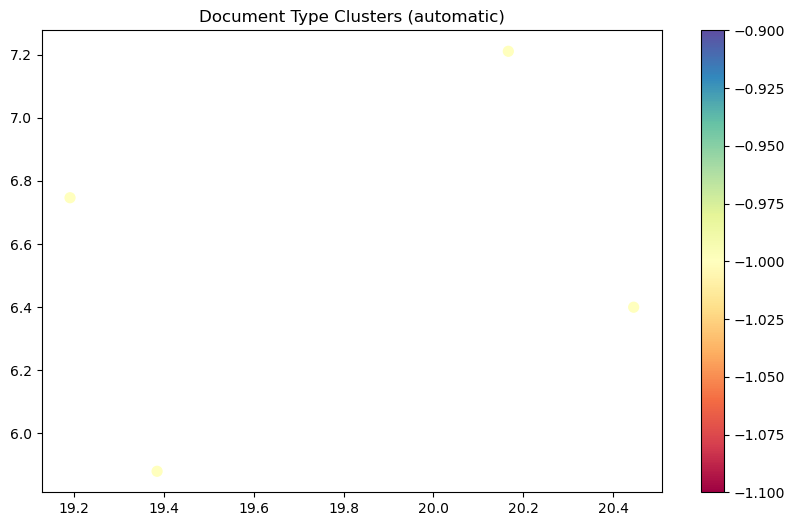

In [ ]:
# Cell 9: Optional - Visualize Clusters
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='cosine')
embedding_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(10,6))
plt.scatter(embedding_2d[:,0], embedding_2d[:,1], c=page_clusters, cmap="Spectral", s=50)
plt.colorbar()
plt.title("Document Type Clusters (automatic)")
plt.show()


In [ ]:
# Cell 10: Enhanced Save Function with Better Naming
def save_enhanced_documents(pdf_path, documents):
    doc = fitz.open(pdf_path)
    saved_files = []
    
    for d in documents:
        new_pdf = fitz.open()
        for page_num in d["pages"]:
            new_pdf.insert_pdf(doc, from_page=page_num, to_page=page_num)
        
        # Create descriptive filename
        filename = f"document_{d['doc_id']}_{d['type']}_pages_{d['start_page']}-{d['end_page']}.pdf"
        new_pdf.save(filename)
        new_pdf.close()
        saved_files.append(filename)
        
        print(f"Saved: {filename}")
    
    doc.close()
    return saved_files

# Save enhanced documents with better naming
print("Saving separated documents...")
saved_files = save_enhanced_documents(pdf_path, enhanced_documents)

print(f"\nSuccessfully separated into {len(saved_files)} documents:")
for filename in saved_files:
    print(f"- {filename}")

# Additional verification step
print("\nDocument separation summary:")
total_original_pages = len(pages)
total_extracted_pages = sum(doc['page_count'] for doc in enhanced_documents)
print(f"Original PDF pages: {total_original_pages}")
print(f"Extracted pages: {total_extracted_pages}")
print(f"Verification: {'✓ Success' if total_original_pages == total_extracted_pages else '✗ Page count mismatch'}")

Saving separated documents...
Saved: document_0_W2_pages_1-2.pdf
Saved: document_1_SSA89_pages_3-4.pdf

Successfully separated into 2 documents:
- document_0_W2_pages_1-2.pdf
- document_1_SSA89_pages_3-4.pdf

Document separation summary:
Original PDF pages: 4
Extracted pages: 4
Verification: ✓ Success
Extracted pages: 4
Verification: ✓ Success


In [ ]:
# Cell 11: Manual Boundary Adjustment (Optional)
# If the automatic detection isn't perfect, you can manually adjust boundaries
# Uncomment and modify the manual_boundaries list below

def manual_document_separation(pdf_path, manual_boundaries):
    """
    Manually specify document boundaries
    manual_boundaries: list of page numbers where new documents start (0-indexed)
    Example: [0, 5, 12] means Doc1: pages 0-4, Doc2: pages 5-11, Doc3: pages 12-end
    """
    manual_boundaries = sorted(set(manual_boundaries))  # Remove duplicates and sort
    if manual_boundaries[0] != 0:
        manual_boundaries.insert(0, 0)
    if manual_boundaries[-1] != len(pages):
        manual_boundaries.append(len(pages))
    
    manual_documents = []
    for i in range(len(manual_boundaries)-1):
        start, end = manual_boundaries[i], manual_boundaries[i+1]
        manual_documents.append({
            "doc_id": i,
            "pages": list(range(start, end)),
            "page_count": end - start,
            "start_page": start + 1,
            "end_page": end
        })
    
    return manual_documents

# Example usage - uncomment and modify as needed:
# manual_boundaries = [0, 10, 20]  # Adjust these page numbers based on your PDF
# manual_docs = manual_document_separation(pdf_path, manual_boundaries)
# saved_files = save_enhanced_documents(pdf_path, manual_docs)

print("Manual adjustment cell added. Uncomment and modify manual_boundaries if needed.")

Manual adjustment cell added. Uncomment and modify manual_boundaries if needed.


In [ ]:
# Cell 12: Diagnostic Information
# This cell helps you understand why boundaries were detected

def show_diagnostics(pages, similarity_scores, boundaries):
    print("=== DIAGNOSTIC INFORMATION ===\n")
    
    # Show similarity scores around boundaries
    print("Similarity scores around detected boundaries:")
    for boundary in boundaries[1:-1]:  # Exclude first and last
        start_idx = max(0, boundary - 2)
        end_idx = min(len(similarity_scores), boundary + 1)
        
        print(f"\nBoundary at page {boundary + 1}:")
        for i in range(start_idx, end_idx):
            marker = " <-- BOUNDARY" if i == boundary - 1 else ""
            if i < len(similarity_scores):
                print(f"  Page {i + 1} -> {i + 2}: {similarity_scores[i]:.3f}{marker}")
    
    # Show page content previews around boundaries
    print("\n" + "="*50)
    print("Page content around boundaries:")
    for boundary in boundaries[1:-1]:
        print(f"\n--- Boundary at page {boundary + 1} ---")
        
        # Show previous page end
        if boundary > 0:
            prev_text = pages[boundary - 1]['text'][-200:].replace('\n', ' ')
            print(f"Previous page end: ...{prev_text}")
        
        # Show next page start  
        if boundary < len(pages):
            next_text = pages[boundary]['text'][:200].replace('\n', ' ')
            print(f"Next page start: {next_text}...")

# Run diagnostics
show_diagnostics(pages, similarity_scores, enhanced_boundaries)

=== DIAGNOSTIC INFORMATION ===

Similarity scores around detected boundaries:

Boundary at page 3:
  Page 1 -> 2: 0.575
  Page 2 -> 3: 0.141 <-- BOUNDARY
  Page 3 -> 4: 0.083

Page content around boundaries:

--- Boundary at page 3 ---
Previous page end: ...efund on Farrn 843, combat pay, See the Form 1040 instructions for details on $ee the Instructions for Form 843. reporting tis amount. R—Employer corrrioulons to your Avcher MSA. Report on Form 8853. 
Next page start: pty fis Cbs Mops Sar arene) ees gees fay ms toe soy ! ans ; Ce RS a Ey ete lk hae ra Toe oe Be Sa sh reo it (te eae a - ms ays r 1 t ey (ew ee 4 ae . ¢ . D . : . ! Vee, ‘ x ayo ¢ we , a tea LAS . ne A...
